## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Importing the dataset

In [2]:
df = pd.read_csv("C:\\Users\\Sarrang\\FindDefault\\transformed_data.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [3]:
df.value_counts('Class')

Class
0    284315
1       492
Name: count, dtype: int64

## Splitting the dataset into the Training set and Test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

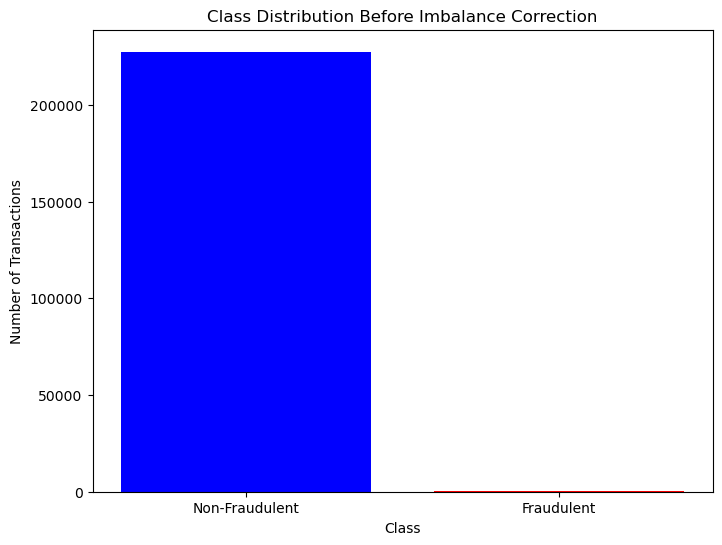

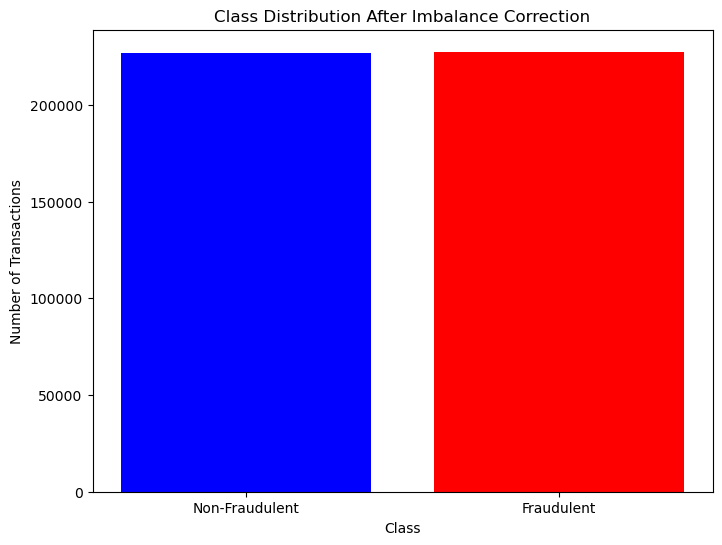

In [6]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color=['blue', 'red'])
plt.xticks(unique_classes, ['Non-Fraudulent', 'Fraudulent'])
plt.title('Class Distribution Before Imbalance Correction')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

# Calculate class distribution after imbalance correction
unique_classes_resampled, class_counts_resampled = np.unique(y_train_resampled, return_counts=True)

# Plot class distribution after imbalance correction
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_resampled, class_counts_resampled, color=['blue', 'red'])
plt.xticks(unique_classes_resampled, ['Non-Fraudulent', 'Fraudulent'])
plt.title('Class Distribution After Imbalance Correction')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

### XGBoost hyperparameter tuning 

In [76]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 25]
}
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid,
                           scoring='precision', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
y_pred = grid_search.predict(X_test)
precision = precision_score(y_test, y_pred)
print("Precision Score:", precision)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'subsample': 0.8}
Precision Score: 0.45751633986928103


In [8]:
import xgboost
classifier=xgboost.XGBClassifier()
"""
USING DEFAULT PARAMETERS IS GIVING BETTER RESULTS THAN ALTERING THEM WITH HYPERPARAMETER TUNING
"""

'\nUSING DEFAULT PARAMETERS IS GIVING BETTER RESULTS THAN ALTERING THEM WITH HYPERPARAMETER TUNING\n'

In [78]:
# classifier=XGBClassifier(colsample_bytree=1.0,
#                              gamma=0.1,
#                              learning_rate=0.2,
#                              max_depth=5,
#                              min_child_weight=1,
#                              scale_pos_weight=1,
#                              subsample=0.8)

In [9]:
classifier.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
y_pred=classifier.predict(X_test)

In [12]:
from sklearn. metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.64      0.80      0.71        87

    accuracy                           1.00     56962
   macro avg       0.82      0.90      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [13]:
import joblib
joblib.dump(classifier,'xgb_smoteENN_FD.joblib')

['xgb_smoteENN_FD.joblib']

[[56836    17]
 [   39    70]]


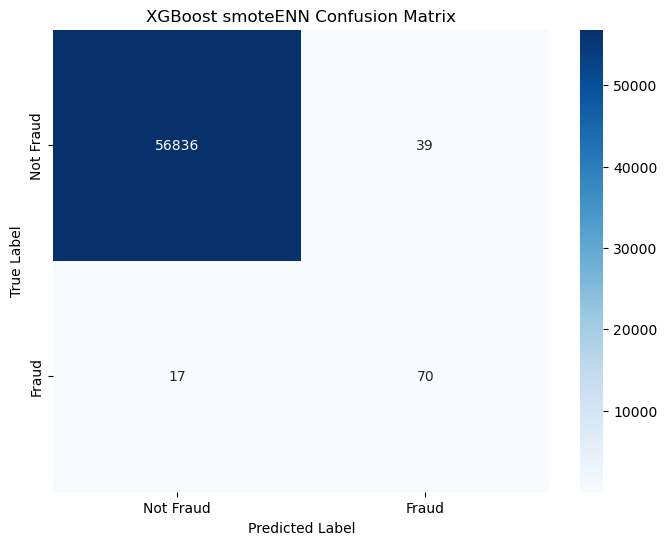

In [5]:
from joblib import load
clf=load("C:\\Users\\Sarrang\\FindDefault\\saved models\\xgb_smoteENN_FD.joblib")
y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost smoteENN Confusion Matrix')
plt.show()

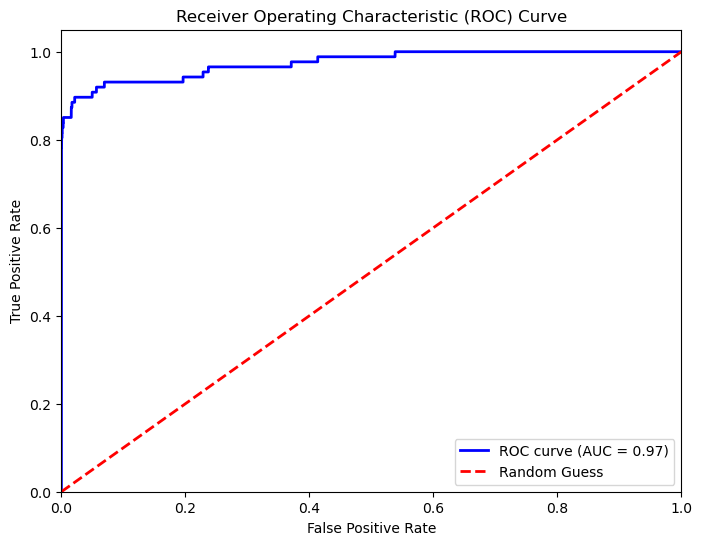

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (fraudulent transactions)
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
